In [1]:
import xarray as xr

In [2]:
# load data
#data_dir = '/data/patricia/20200320_Test_Run/'
#data_dir = '/data/segmentation/20200227_IF_Testing/'
data_dir = '/data/alex/test_image/'
cohort_xr = xr.open_dataarray(data_dir + 'deepcell_input.xr')
cohort_xr.shape

(1, 2516, 2476, 2)

In [20]:
from skimage.transform import resize
bigger_vals = resize(cohort_xr.values, [1, cohort_xr.shape[1] * 2, cohort_xr.shape[2] * 2, 2], order=3, preserve_range=True)

In [3]:
import os
import errno
import numpy as np 
import deepcell

In [4]:
# whole-cell model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20200227_IF_Training/20200315_IF_Training_5_deep_watershed.h5")

W0327 22:05:13.858721 140633174816576 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


94773248/94765736 [==============================] - 3s 0us/step


In [31]:
# mibi friendly model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20200227_IF_Training/20200310_IF_Training_1_deep_watershed.h5")

In [5]:
# decidua model
from deepcell.model_zoo.panopticnet import PanopticNet

model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 6),
    norm_method='std',
    num_semantic_heads=4,
    num_semantic_classes=[1, 1, 2, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

model.load_weights("/data/models/20191113_Decidua_Shirley_Relabel/Decidua_caliban_v4_blanked_fix2_stride_0.5_deep_watershed_pixel_transform_20_epoch.h5")

W0317 02:00:36.740812 139780376278848 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
from deepcell_toolbox.utils import tile_image

In [24]:
test_data, test_info = tile_image(bigger_vals[:, ...], (256, 256), stride_ratio=0.75)

In [25]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = model.predict(test_data)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape, 'in', watershed_time, 'seconds.')

Watershed segmentation of shape (676, 256, 256, 1) in 5.701182138999911 seconds.


In [26]:
inner_distance, outer_distance, fgbg, pixelwise = test_images

In [27]:
def untile_image(tiles, tiles_info, dtype,
                 model_input_shape=(512, 512)):
    """Untile a set of tiled images back to the original model shape.
    Args:
        tiles (numpy.array): The tiled images image to untile.
        tiles_info (dict): Details of how the image was tiled (from tile_image).
        model_input_shape (tuple): The input size of the model.
    Returns:
        numpy.array: The untiled image.
    """
    _axis = 1
    image_shape = tiles_info['image_shape']
    batches = tiles_info['batches']
    x_starts = tiles_info['x_starts']
    x_ends = tiles_info['x_ends']
    y_starts = tiles_info['y_starts']
    y_ends = tiles_info['y_ends']
    stride_x = tiles_info['stride_x']
    stride_y = tiles_info['stride_y']

    tile_size_x = model_input_shape[0]
    tile_size_y = model_input_shape[1]

    image_shape = tuple(list(image_shape[0:3]) + [tiles.shape[-1]])
    image = np.zeros(image_shape, dtype=dtype)

    zipped = zip(tiles, batches, x_starts, x_ends, y_starts, y_ends)
    for tile, batch, x_start, x_end, y_start, y_end in zipped:
        tile_x_start = 0
        tile_x_end = tile_size_x
        tile_y_start = 0
        tile_y_end = tile_size_y

        if x_start != 0:
            x_start += (tile_size_x - stride_x) / 2
            tile_x_start += (tile_size_x - stride_x) / 2
        if x_end != image_shape[_axis]:
            x_end -= (tile_size_x - stride_x) / 2
            tile_x_end -= (tile_size_x - stride_x) / 2
        if y_start != 0:
            y_start += (tile_size_y - stride_y) / 2
            tile_y_start += (tile_size_y - stride_y) / 2
        if y_end != image_shape[_axis]:
            y_end -= (tile_size_y - stride_y) / 2
            tile_y_end -= (tile_size_y - stride_y) / 2

        x_start = np.int(x_start)
        x_end = np.int(x_end)
        y_start = np.int(y_start)
        y_end = np.int(y_end)

        tile_x_start = np.int(tile_x_start)
        tile_x_end = np.int(tile_x_end)
        tile_y_start = np.int(tile_y_start)
        tile_y_end = np.int(tile_y_end)

        image[batch, x_start:x_end, y_start:y_end, :] = \
            tile[tile_x_start:tile_x_end, tile_y_start:tile_y_end, :]

    return image

In [28]:
inner_distance_untile = untile_image(inner_distance, test_info, "float32", (256, 256))
outer_distance_untile = untile_image(outer_distance, test_info, "float32",(256, 256))
pixelwise_untile = untile_image(pixelwise, test_info, "float32", (256, 256))
fgbg_untile = untile_image(fgbg, test_info, "float32", (256, 256))
pixelwise_sum = pixelwise_untile[:, :, :, :1] + pixelwise_untile[:, :, :, 1:2] 

In [29]:
combined = np.concatenate((pixelwise_untile[:, :, :, 1:2], pixelwise_untile[:, :, :, 0:1], 
                           inner_distance_untile, outer_distance_untile, fgbg_untile[:, :, :, 1:2],
                          pixelwise_sum), axis=-1)
combined.shape

(1, 5032, 4952, 6)

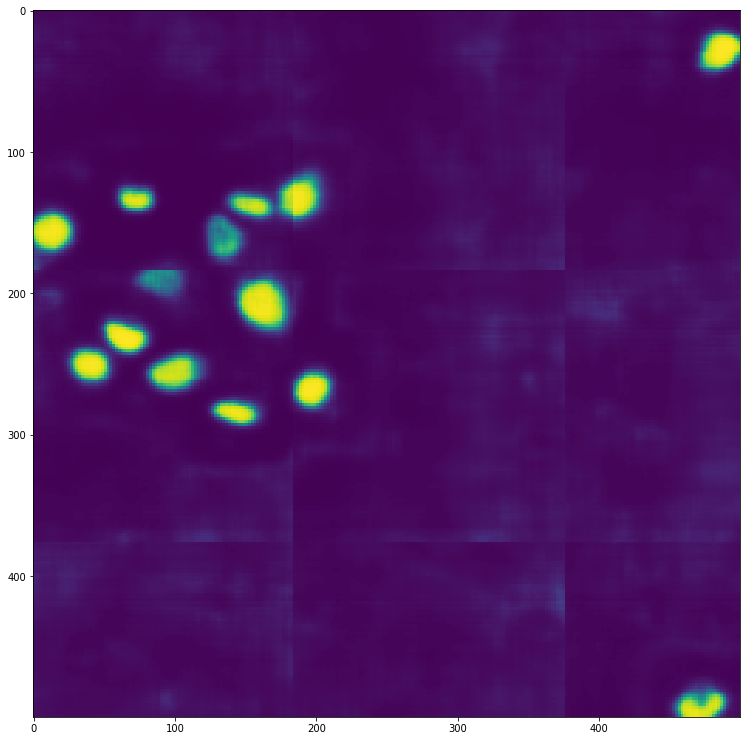

In [30]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(combined[0, 1000:1500, 1000:1500, 0])

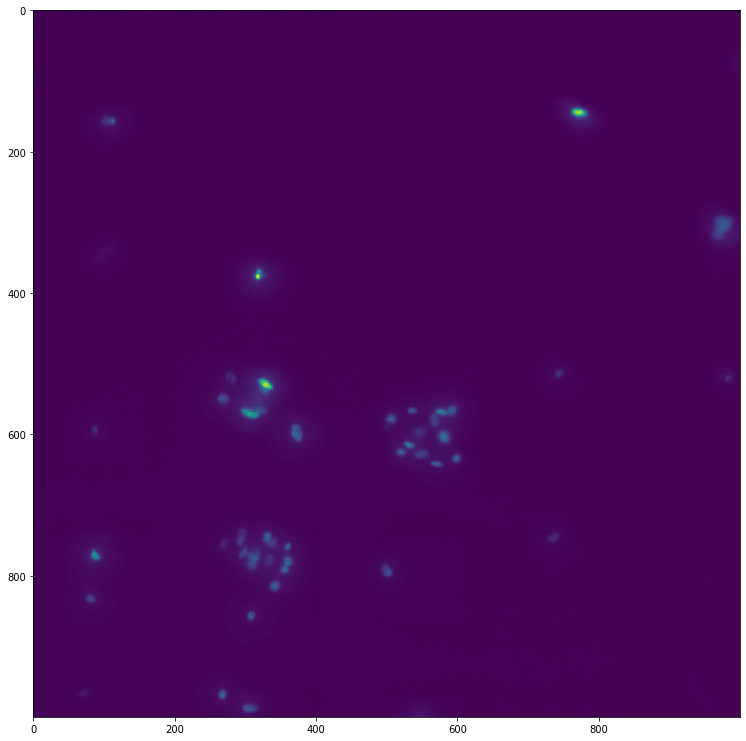

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize = (13, 13))
plt.imshow(cohort_xr[0, :1000, :1000, 0])

In [32]:
model_output = xr.DataArray(combined,
                         coords=[cohort_xr.coords['fovs'], range(bigger_vals.shape[1]), 
                                 range(bigger_vals.shape[2]), 
                                 ['pixelwise_interior', 'pixelwise_border', 'watershed_inner', 
                                  'watershed_outer', 'fgbg_foreground', 'pixelwise_sum']],
                         dims=['fovs', 'rows', 'cols', 'models'])
model_output.to_netcdf(os.path.join(data_dir, "deepcell_output.xr"), format="NETCDF4")